<a href="https://colab.research.google.com/github/musicjae/intro_to_python/blob/master/Pytorch/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/zergtant/pytorch-handbook/blob/master/chapter1/neural_networks_tutorial.ipynb

In [214]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time


# 1 Data Load

In [215]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [216]:
ROOT = '.data'

train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True
                           )

 Normalizing our data allows our models to train faster and to also help them avoid local minima, i.e. train more reliably.

- To calculate the means and standard deviations we get the actual data (the images) using the .data. attribute of our training data, convert them into floating point numbers and then use the built in mean and std functions

# Preprocessing


## mean,std

In [217]:
mean = train_data.data.float().mean()/255
std = train_data.data.float().std()/255

In [218]:
print(mean, std)

tensor(0.1307) tensor(0.3081)


## transforms

- A transform states how our data should be augmented and processed  
- We use transforms.Compose to built a list of transformations that will be applied to the image.

In [274]:
train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])

In [260]:
ROOT = '.data'

train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True,
                            transform = train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform = test_transforms
                           )

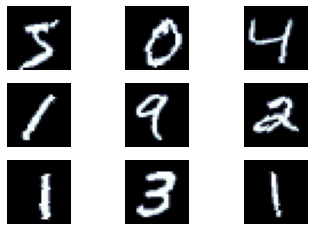

In [261]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.axis('off')

N_IMAGES = 10

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

## split dataset

In [262]:
VAL_RATE = 0.9
n_train_ex = int(len(train_data)*VAL_RATE)
n_val_ex = len(train_data) - n_train_ex
train_data, valid_data = data.random_split(train_data,[n_train_ex, n_val_ex])

In [263]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


As the validation set is a Subset of the training set, if we change the transforms of one then by default Torchvision will change the transforms of the other. To stop this from happening we make a deepcopy of the validation data.

In [264]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [265]:
print(type(train_data))

torch.utils.data.dataset.Subset


## dataloader

In [286]:
BATCH_SIZE = 50

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                 batch_size = BATCH_SIZE)

# Model

In [287]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,10,5)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10,20,3)
        self.bn2 = nn.BatchNorm2d(20)
        #affine
        self.fc1 = nn.Linear(64,500)
        self.fc2 = nn.Linear(500,10)

    def forward(self, x):

        #x = x.permute(0,1,2,3)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2,2) # # batch*10*24*24 -> batch*10*12*12

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2,2)

        x = x.view(-1, 16*2*2) # Flattening  # batch*20*10*10 -> batch*2000（
        #x = x.Flattening(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        
        return F.log_softmax(x,dim=1)

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [268]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

2425914


# preparing

In [288]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [289]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [290]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss=0
    
    model.train()
    for (x,y) in iterator:
        x=x.to(device)
        y=y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
    
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/len(iterator)

In [291]:
def evaluate(model, iterator, optimizer, criterion, device):

    epoch_loss=0
    
    model.eval()

    with torch.no_grad():

        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)

            y_pred = model(x)
    
            loss = criterion(y_pred, y)

            epoch_loss += loss.item()

    return epoch_loss/len(iterator)

# Train & Eval

In [292]:
EPOCHS = 10

for epoch in range(EPOCHS):

    train_loss = train(model,train_iterator,optimizer,criterion,device)
    valid_loss = evaluate(model, valid_iterator,criterion, device)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

RuntimeError: ignored